# Rainfall Prediction Project
Predict rainfall for Indian districts using historical data.

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# from src.data_prep import load_raw, clean_dates
# from src.features import create_time_features
# from src.models import build_rf_pipeline, save_model
# from src.evaluate import rmse, mae


In [ ]:
# Rainfall Prediction Project - Self Contained Notebook

# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
from datetime import timedelta, datetime

# --- 1. Functions ---

# Data loading and cleaning
def load_and_clean_data(path):
    df = pd.read_csv(path)
    df = df.dropna(subset=['Date']).copy()
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
    df = df.dropna(subset=['Date']).copy()
    df['Day'] = df['Date'].dt.day
    df['Weekday'] = df['Date'].dt.day_name()
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    return df

# Feature engineering
def create_time_features(df, group_col='District', target='Avg_rainfall', lags=[1,2,3,7], windows=[3,7]):
    df = df.sort_values([group_col,'Date']).copy()
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby(group_col)[target].shift(lag)
    for w in windows:
        df[f'roll_mean_{w}'] = df.groupby(group_col)[target].shift(1).rolling(window=w, min_periods=1).mean().reset_index(level=0, drop=True)
    return df

# Model building
def build_rf_pipeline(numeric_features, categorical_features):
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
    model = Pipeline(steps=[
        ('pre', preprocessor),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
    ])
    return model

# Evaluation metrics
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

# 7-day forecast
def forecast_7_days(model, df_hist, features, start_date):
    last_known = df_hist.iloc[-1].copy()
    forecast_dates = []
    forecast_values = []
    for i in range(7):
        X_input = last_known[features].values.reshape(1,-1)
        val = model.predict(X_input)[0]
        forecast_values.append(val)
        forecast_dates.append(start_date + timedelta(days=i+1))
        # Update lag features
        last_known['lag_3'] = last_known['lag_2']
        last_known['lag_2'] = last_known['lag_1']
        last_known['lag_1'] = val
        last_known['roll_mean_7'] = np.mean([last_known['lag_1'], last_known['lag_2'], last_known['lag_3']])
    return forecast_dates, forecast_values

# --- 2. Load & clean data ---
# df = load_and_clean_data("data/raw/sample_rainfall.csv")
df = load_and_clean_data(r'C:\Users\hp\Documents\ds_materials\9.Deep_learning\project\Rainfall Pattern Prediction\rainfall_prediction_project\data\raw\sample_rainfall.csv')

df.head()


# --- 3. EDA ---
plt.figure(figsize=(8,4))
sns.histplot(df['Avg_rainfall'], bins=30, kde=True, color='skyblue')
plt.title('Rainfall Distribution')
plt.xlabel('Avg_rainfall (mm)')
plt.show()

monthly_avg = df.groupby('Month')['Avg_rainfall'].mean().reset_index()
plt.figure(figsize=(8,4))
sns.barplot(x='Month', y='Avg_rainfall', data=monthly_avg, palette='viridis')
plt.title('Average Rainfall per Month')
plt.show()

# --- 4. Feature engineering ---
df = create_time_features(df)
df.dropna(subset=['lag_1'], inplace=True)
df.head()

# --- 5. Model training ---
num_features = ['lag_1','lag_2','lag_3','roll_mean_7','Day','Month']
cat_features = ['District']
X = df[num_features + cat_features]
y = df['Avg_rainfall']

split_idx = int(0.8*len(df))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

model = build_rf_pipeline(num_features, cat_features)
model.fit(X_train, y_train)

# Save model
import os
os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/rf_model.joblib")

# --- 6. Evaluation ---
y_pred = model.predict(X_test)
print('RMSE:', rmse(y_test, y_pred))
print('MAE:', mae(y_test, y_pred))

# --- 7. 7-day forecast example ---
district = 'South East'
df_hist = df[df['District']==district].sort_values('Date')
start_date = df_hist['Date'].max()

forecast_dates, forecast_values = forecast_7_days(model, df_hist, num_features + cat_features, start_date)

plt.figure(figsize=(10,4))
plt.plot(forecast_dates, forecast_values, marker='o', color='blue')
plt.title(f'7-Day Forecast for {district}')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.grid(True)
plt.show()


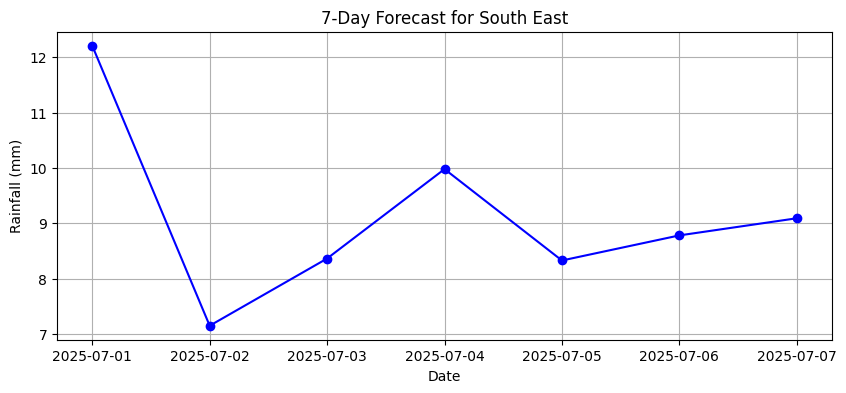

In [16]:
def forecast_7_days(model, df_hist, features, start_date):
    last_known = df_hist.iloc[-1].copy()
    forecast_dates = []
    forecast_values = []
    for i in range(7):
        X_input = pd.DataFrame([last_known])[features]  # convert to DataFrame
        val = model.predict(X_input)[0]
        forecast_values.append(val)
        forecast_dates.append(start_date + timedelta(days=i+1))
        # Update lag features
        last_known['lag_3'] = last_known['lag_2']
        last_known['lag_2'] = last_known['lag_1']
        last_known['lag_1'] = val
        last_known['roll_mean_7'] = np.mean([last_known['lag_1'], last_known['lag_2'], last_known['lag_3']])
    return forecast_dates, forecast_values



# --- 7. 7-day forecast example ---
district = 'South East'
df_hist = df[df['District']==district].sort_values('Date')
start_date = df_hist['Date'].max()

forecast_dates, forecast_values = forecast_7_days(model, df_hist, num_features + cat_features, start_date)

plt.figure(figsize=(10,4))
plt.plot(forecast_dates, forecast_values, marker='o', color='blue')
plt.title(f'7-Day Forecast for {district}')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.grid(True)
plt.show()


## 1. Load & Clean Data

In [ ]:
df = load_raw(r'C:\Users\hp\Documents\ds_materials\9.Deep_learning\project\Rainfall Pattern Prediction\rainfall_prediction_project\data\raw\sample_rainfall.csv')
df = clean_dates(df)
df.head()

,Unnamed: 0,State,District,Date,Year,Month,Avg_rainfall,Day,Weekday
0,0,Delhi,North,2024-12-09,2024,12,0.000898,9,Monday
1,1,Delhi,North,2024-12-10,2024,12,0.000000,10,Tuesday
2,2,Delhi,North,2024-12-13,2024,12,0.000000,13,Friday
3,3,Delhi,North,2024-12-15,2024,12,0.000000,15,Sunday
4,4,Delhi,North,2024-12-19,2024,12,0.000000,19,Thursday


## 2. Exploratory Data Analysis (EDA)

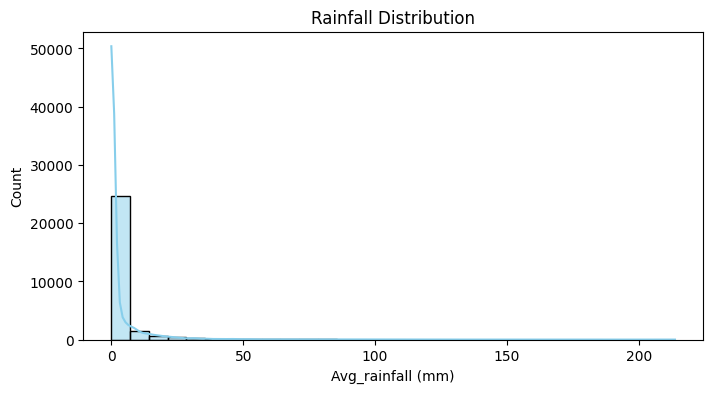

C:\Users\hp\AppData\Local\Temp\ipykernel_15852\1344566689.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Month', y='Avg_rainfall', data=monthly_avg, palette='viridis')


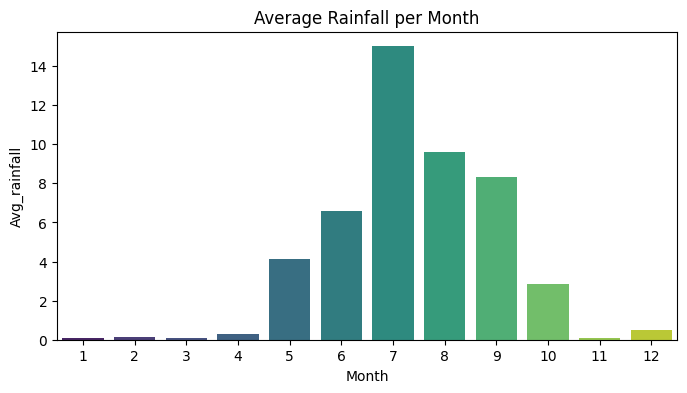

In [9]:
# Rainfall distribution
plt.figure(figsize=(8,4))
sns.histplot(df['Avg_rainfall'], bins=30, kde=True, color='skyblue')
plt.title('Rainfall Distribution')
plt.xlabel('Avg_rainfall (mm)')
plt.show()

# Monthly rainfall trend
monthly_avg = df.groupby('Month')['Avg_rainfall'].mean().reset_index()
plt.figure(figsize=(8,4))
sns.barplot(x='Month', y='Avg_rainfall', data=monthly_avg, palette='viridis')
plt.title('Average Rainfall per Month')
plt.show()

## 3. Feature Engineering

In [10]:
df = create_time_features(df)
df.dropna(subset=['lag_1'], inplace=True)
df.head()

NameError: name 'create_time_features' is not defined

## 4. Model Training

In [ ]:
# Features & target
num_features = ['lag_1','lag_2','lag_3','roll_mean_7','Day','Month']
cat_features = ['District']
X = df[num_features + cat_features]
y = df['Avg_rainfall']

# Train-test split (time-based)
split_idx = int(0.8*len(df))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Build & train model
model = build_rf_pipeline(num_features, cat_features)
model.fit(X_train, y_train)

# Save model
save_model(model, 'models/rf_model.joblib')

## 5. Model Evaluation

In [ ]:
y_pred = model.predict(X_test)
print('RMSE:', rmse(y_test, y_pred))
print('MAE:', mae(y_test, y_pred))

## 6. 7-Day Forecast Example

In [ ]:
district = 'South East'
df_hist = df[df['District']==district].sort_values('Date')
last_known = df_hist.iloc[-1].copy()
forecast_dates = []
forecast_values = []

from datetime import timedelta
start_date = last_known['Date']

for i in range(7):
    X_input = last_known[num_features + cat_features].values.reshape(1,-1)
    val = model.predict(X_input)[0]
    forecast_values.append(val)
    forecast_dates.append(start_date + timedelta(days=i+1))
    # Update lag features
    last_known['lag_3'] = last_known['lag_2']
    last_known['lag_2'] = last_known['lag_1']
    last_known['lag_1'] = val
    last_known['roll_mean_7'] = np.mean([last_known['lag_1'], last_known['lag_2'], last_known['lag_3']])

# Plot forecast
plt.figure(figsize=(10,4))
plt.plot(forecast_dates, forecast_values, marker='o', color='blue')
plt.title(f'7-Day Forecast for {district}')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.grid(True)
plt.show()